In [11]:
import os
import psycopg2
import pandas as pd
from dotenv import load_dotenv
import numpy as np
import plotly.graph_objects as go # for candlestick chart
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys
import os

# Load environment variables from .env file
load_dotenv()

# Database configuration from environment variables
db_config = {
    "host": os.getenv("DB_HOST"),
    "port": os.getenv("DB_PORT"),
    "user": os.getenv("DB_USER"),
    "password": os.getenv("DB_PASSWORD"),
    "dbname": os.getenv("DB_NAME")
}

def read_data(table_name):
    """
    Read data from the specified PostgreSQL table and return it as a DataFrame.
    """
    try:
        # Connect to the PostgreSQL database
        conn = psycopg2.connect(**db_config)
        
        # Create a cursor object
        cursor = conn.cursor()
        
        # Execute a query to fetch data
        query = f"SELECT * FROM {table_name};"
        cursor.execute(query)
        
        # Fetch all rows from the executed query
        rows = cursor.fetchall()
        
        # Convert the data to a Pandas DataFrame
        columns = [desc[0] for desc in cursor.description]  # Get column names
        df = pd.DataFrame(rows, columns=columns)
        
        # Convert the 'date' column to datetime
        df['date'] = pd.to_datetime(df['date'], errors='coerce')  # Convert to datetime
        
        return df  # Return the DataFrame
        
    except Exception as e:
        print(f"Error reading data from PostgreSQL: {e}")
        return None  # Return None in case of an error
    finally:
        if conn:
            cursor.close()
            conn.close()

# Call the function to read data from the specified table and assign it to df
df = read_data("historical_stock_data")

# Now df is defined and can be used outside the function
if df is None:
     print("No data was retrieved.")

In [12]:
data = df.sort_values(by='date').reset_index(drop=True)
display(df)

,date,open,high,low,close,adj_close,volume,stock_name
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.447412,493729600,AAPL
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.458559,601904800,AAPL
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.355828,552160000,AAPL
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.344076,477131200,AAPL
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.386254,447610800,AAPL
...,...,...,...,...,...,...,...,...
33230,2024-12-23,21566.000000,21776.750000,21476.750000,21753.250000,21753.250000,508598,NQ=F
33231,2024-12-24,21743.250000,22049.750000,21709.000000,22028.500000,22028.500000,261201,NQ=F
33232,2024-12-26,22049.500000,22111.250000,21870.250000,22008.000000,22008.000000,407116,NQ=F
33233,2024-12-27,21990.750000,22008.000000,21498.750000,21698.500000,21698.500000,572604,NQ=F


## Feature Engineering

In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Özellik mühendisliği (önceki adımlardaki gibi)
data['Pct_Change'] = data['adj_close'].pct_change()
data['MA7'] = data['adj_close'].rolling(window=7).mean()
data['MA30'] = data['adj_close'].rolling(window=30).mean()
data['Momentum'] = data['adj_close'].diff(10)
data['MA20'] = data['adj_close'].rolling(window=20).mean()
data['BB_Upper'] = data['MA20'] + 2*data['adj_close'].rolling(window=20).std()
data['BB_Lower'] = data['MA20'] - 2*data['adj_close'].rolling(window=20).std()
data['EMA12'] = data['adj_close'].ewm(span=12, adjust=False).mean()
data['EMA26'] = data['adj_close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA12'] - data['EMA26']
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()
data['Volatility'] = data['adj_close'].rolling(window=10).std()
data['OBV'] = (data['volume'] * ((data['adj_close'] - data['adj_close'].shift(1)) > 0).astype(int) * 2 - 1).cumsum()
data['Williams_%R'] = (data['high'].rolling(14).max() - data['adj_close']) / (data['high'].rolling(14).max() - data['low'].rolling(14).min()) * -100

# Boş verileri kaldır
data = data.dropna()

# Hedef değişkeni oluştur (Buy, Sell, Hold)
def get_signal(df):
    conditions = [
        (df['Pct_Change'] > 0.02),
        (df['Pct_Change'] < -0.02)
    ]
    choices = ['Buy', 'Sell']
    df['Signal'] = np.select(conditions, choices, default='Hold')
    return df

data = get_signal(data)

# Girdi ve hedef değişkenlerini ayıralım
X = data[['Pct_Change', 'MA7', 'MA30', 'Momentum', 'BB_Upper', 'BB_Lower', 'MACD', 'Signal_Line', 'Volatility', 'OBV', 'Williams_%R']]
y = data['Signal']

# Label Encoding (y'yi sayısal hale getirmek için)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Veriyi normalleştirme
scaler = StandardScaler()
X = scaler.fit_transform(X)

# LSTM modeline uygun hale getirmek için veriyi yeniden şekillendirelim
def reshape_for_lstm(X, y, time_steps=30):
    X_lstm, y_lstm = [], []
    for i in range(len(X) - time_steps):
        X_lstm.append(X[i:i + time_steps, :])
        y_lstm.append(y[i + time_steps])
    return np.array(X_lstm), np.array(y_lstm)

# 30 günlük zaman penceresi ile veriyi LSTM'e uygun hale getirelim
X_lstm, y_lstm = reshape_for_lstm(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.3, random_state=42)


Epoch 1/50


c:\Users\deadp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


726/726 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.5850 - loss: 0.7311 - val_accuracy: 0.6918 - val_loss: 0.6115
Epoch 2/50
726/726 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.6854 - loss: 0.6232 - val_accuracy: 0.6904 - val_loss: 0.6123
Epoch 3/50
726/726 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.6841 - loss: 0.6209 - val_accuracy: 0.6901 - val_loss: 0.6081
Epoch 4/50
726/726 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.6867 - loss: 0.6169 - val_accuracy: 0.6954 - val_loss: 0.6064
Epoch 5/50
726/726 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.6931 - loss: 0.6094 - val_accuracy: 0.6849 - val_loss: 0.6112
Epoch 6/50
726/726 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.6901 - loss: 0.6110 - val_accuracy: 0.6896 - val_loss: 0.6034
Epoch 7/50
726/726 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.6869 - loss: 0.6061 - val_accuracy: 0.6888 - val_loss: 0.6034
Epoch 8/50
726/726 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.6942 - loss: 0.6047 - val_accurac

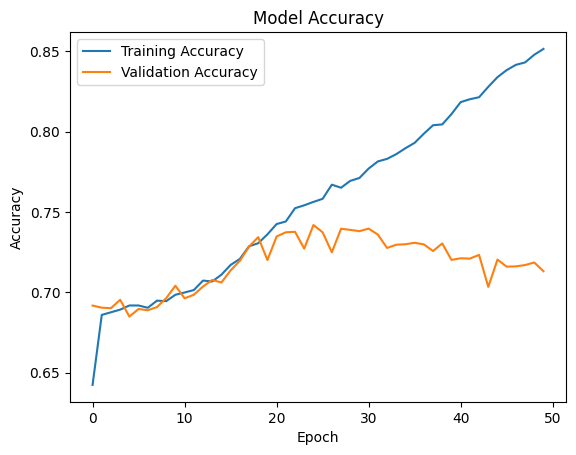

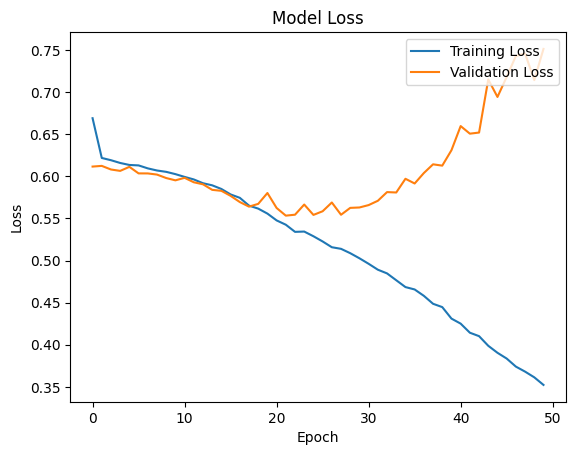

312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
              precision    recall  f1-score   support

         Buy       0.70      0.75      0.72      4861
        Hold       0.11      0.01      0.01       145
        Sell       0.73      0.70      0.71      4947

    accuracy                           0.71      9953
   macro avg       0.51      0.48      0.48      9953
weighted avg       0.71      0.71      0.71      9953



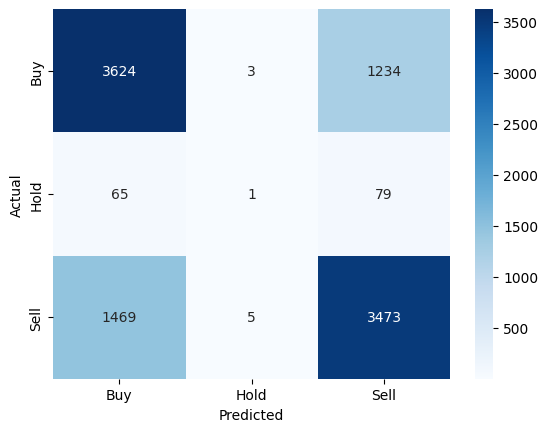

In [14]:
model = Sequential()

# İlk LSTM katmanı
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.3))

# İkinci LSTM katmanı
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))

# Çıkış katmanı
model.add(Dense(3, activation='softmax'))  # 3 sınıf (Buy, Sell, Hold)

# Modeli derleme
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Modeli eğitme
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Performansı değerlendirme
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

#### Python Kodları

import matplotlib.pyplot as plt

# Eğitim ve doğrulama doğruluğu grafiği
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Eğitim ve doğrulama kaybı grafiği
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


# Test verisi üzerindeki tahminler
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Gerçek ve tahmin edilen sınıfları karşılaştıralım
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
